In [1]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll
!pip install musicautobot
!pip install midi2audio

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6 MB 4.3 MB/s 
     |████████████████████████████████| 51 kB 5.9 MB/s 


In [2]:
!pip install FluidSynth

  Created wheel for FluidSynth: filename=fluidsynth-0.2-py3-none-any.whl size=4514 sha256=5dc7fc6e3100b313cc5daa67749398aafcf9db3885206843bbce7f815dd5afb5
  Stored in directory: /root/.cache/pip/wheels/44/4b/81/dee2d535b2dd27af13c230ba49aa6f05a5dff0f57c68acef55
Successfully built FluidSynth


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import torchvision
from torch.utils.data import TensorDataset, DataLoader

In [4]:
import torch
import os
import json
import pandas as pd
import numpy as np
import torch
import pypianoroll
from datetime import datetime
root_dir = 'drive/MyDrive/Colab Notebooks/Pianorolls'
data_dir = root_dir + '/lpd/lpd_cleansed'
music_dataset_lpd_dir = root_dir + '/lpd/lpd_cleansed'

In [5]:
from music21 import *
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils import midifile
from midi2audio import FluidSynth

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [156]:
root_dir = 'drive/MyDrive/Deep Learning Project'
combined_pianorolls = torch.load(os.path.join(root_dir, 'Pianorolls', 'pianorolls.pt'))
pianoroll_lengths = torch.load(os.path.join(root_dir, 'Pianorolls', 'pianorolls_lengths.pt'))

In [157]:
datas = torch.vstack(combined_pianorolls)

In [158]:
input = torch.empty(datas.shape[0], 1)
temp_targets = torch.zeros_like(input)

In [159]:
batch_size = 1000
t = datas > 0
datas[t==True] = 1.0
datas[t==False] = 0.0

train_data = TensorDataset(datas.view(-1, 128).float(),temp_targets)
test_data = TensorDataset(datas.view(-1, 128).float(), temp_targets)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [160]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        # self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc21 = nn.Linear(h_dim1, z_dim)
        self.fc22 = nn.Linear(h_dim1, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim1)
        # self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc5 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        # h = F.relu(self.fc2(h))
        return self.fc21(h), self.fc22(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = torch.tanh(self.fc4(z))
        # h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc5(h)) 
    
    def forward(self, x):
        # mu, log_var = self.encoder(x.view(-1, 196))
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=128, h_dim1= 64, h_dim2=256, z_dim=8)
if torch.cuda.is_available():
    vae.cuda()

In [161]:
vae

VAE(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc21): Linear(in_features=64, out_features=8, bias=True)
  (fc22): Linear(in_features=64, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=128, bias=True)
)

In [162]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = -F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))
    return BCE - KLD

In [163]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)

        loss = -loss_function(recon_batch, data, mu, log_var)
        
        (loss).backward()
        train_loss += loss.item()

        optimizer.step()
        
        if batch_idx % 100 == 0:

            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * 100, 959972,
                (100. * batch_idx) / 959972, loss.item() / 100))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / 959972))
    print(mu.shape, log_var.shape)
    return mu, log_var

In [164]:
final_mu, final_log_var = 0, 0

for epoch in range(1, 10):
    final_mu, final_log_var = train(epoch)

Train Epoch: 1 [0/959972 (0%)]	Loss: 899.666328
Train Epoch: 1 [10000/959972 (0%)]	Loss: 151.132285
Train Epoch: 1 [20000/959972 (0%)]	Loss: 121.183047
Train Epoch: 1 [30000/959972 (0%)]	Loss: 115.332168
Train Epoch: 1 [40000/959972 (0%)]	Loss: 114.999492
Train Epoch: 1 [50000/959972 (0%)]	Loss: 107.029609
Train Epoch: 1 [60000/959972 (0%)]	Loss: 108.978623
Train Epoch: 1 [70000/959972 (0%)]	Loss: 110.250273
Train Epoch: 1 [80000/959972 (0%)]	Loss: 100.111582
Train Epoch: 1 [90000/959972 (0%)]	Loss: 97.985957
====> Epoch: 1 Average loss: 14.6932
torch.Size([972, 8]) torch.Size([972, 8])
Train Epoch: 2 [0/959972 (0%)]	Loss: 96.197861
Train Epoch: 2 [10000/959972 (0%)]	Loss: 94.445342
Train Epoch: 2 [20000/959972 (0%)]	Loss: 92.110225
Train Epoch: 2 [30000/959972 (0%)]	Loss: 89.548213
Train Epoch: 2 [40000/959972 (0%)]	Loss: 83.470977
Train Epoch: 2 [50000/959972 (0%)]	Loss: 83.510781
Train Epoch: 2 [60000/959972 (0%)]	Loss: 83.066709
Train Epoch: 2 [70000/959972 (0%)]	Loss: 81.689321
Tr

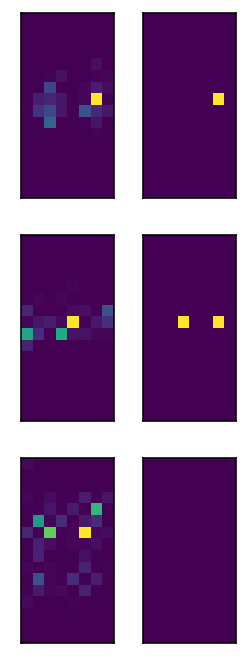

In [180]:
indices = torch.randint(0, 10000, (3,))
i = 0
fig = plt.figure(figsize=(2, 16))
with torch.no_grad():
  for index in indices:
    data = datas[index].float().view(-1, 128).cuda()
    recon_batch, mu, log_var = vae(data)
    ax1 = fig.add_subplot(8, 2, i+1, xticks=[], yticks=[])
    ax1.imshow(recon_batch.view(16, 8).cpu())
    i += 1
    ax1 = fig.add_subplot(8, 2, i+1, xticks=[], yticks=[])
    ax1.imshow(data.view(16, 8).cpu())
    i += 1

In [179]:
bigline = []
bigline_std = []
m = torch.distributions.MultivariateNormal(torch.zeros(8), torch.eye(8))

#Sampling with mu, log_var obtained from encoding one of the samples
with torch.no_grad():
  for i in range(20):
    z = vae.sampling(final_mu,final_mu)
    ind = torch.randint(0, 972,(1,))
    z_new = z[0]
    sample = vae.decoder(z_new).cuda()
    bigline.append(torch.argmax(sample).item())



In [173]:
#Sampling with a standard normal
with torch.no_grad():
  for i in range(20):
    z = m.sample().cuda()
    sample = vae.decoder(z).cuda()
    bigline_std.append(torch.argmax(sample).item())

In [174]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.3

    midi_stream = stream.Stream(output_notes)
    return midi_stream

generated_path = os.path.join(root_dir, 'Generated MIDIs/VAE MIDIs', 'sample3.mid')
generated_stream = create_midi(bigline)
generated_stream.write('midi', fp=generated_path)
generated_path = os.path.join(root_dir, 'Generated MIDIs/VAE MIDIs', 'sample5.mid')
generated_stream = create_midi(bigline_std)
generated_stream.write('midi', fp=generated_path)

'drive/MyDrive/Deep Learning Project/Generated MIDIs/VAE MIDIs/sample5.mid'